### Emergency Detection

In [1]:
import pandas as pd
from detection import emergency_detection_workflow, prepare_data_for_detection, detect_emergency
from base.minio_utils import load_model_from_minio
from base.influx_utils import fetch_all_sensor_data
from base.homecare_hub_utils import send_info, send_todo

In [2]:
sensor_data = fetch_all_sensor_data(
    start_hours=24,
    interval_hours=24
)
prepared_df = prepare_data_for_detection(sensor_data)
prepared_df.tail(5)

2025-01-03 16:20:39 [INFO] detection - Starting data preparation for detection.
2025-01-03 16:20:39 [INFO] detection - Original data shape: (1096, 5)
2025-01-03 16:20:39 [INFO] detection - Handled 'sensor' as a list.
2025-01-03 16:20:39 [INFO] detection - Timestamps converted to datetime.
2025-01-03 16:20:39 [INFO] detection - Data sorted by timestamp.
2025-01-03 16:20:39 [INFO] detection - Sensor names encoded successfully.
2025-01-03 16:20:39 [INFO] detection - Mapped sensors to rooms.
2025-01-03 16:20:39 [INFO] detection - Identified room-change points and assigned group IDs.
2025-01-03 16:20:39 [INFO] detection - Calculated start and end times for each group.
2025-01-03 16:20:39 [INFO] detection - Computed durations for each group.
2025-01-03 16:20:39 [INFO] detection - Data preparation for detection completed.


,group_id,room,start_time,end_time,duration,duration_seconds
80,81,kitchen,2025-01-03 11:20:04.632,2025-01-03 11:31:46.201,0 days 00:11:41.569000,701.569
81,82,bathroom,2025-01-03 11:33:54.773,2025-01-03 11:33:54.773,0 days 00:00:00,0.000
82,83,kitchen,2025-01-03 11:35:58.009,2025-01-03 12:18:42.269,0 days 00:42:44.260000,2564.260
83,84,bathroom,2025-01-03 12:21:18.244,2025-01-03 12:21:32.604,0 days 00:00:14.360000,14.360
84,85,kitchen,2025-01-03 12:27:02.348,2025-01-03 15:10:48.206,0 days 02:43:45.858000,9825.858


In [3]:
room_stats = load_model_from_minio("occupancy")
room_stats

2025-01-03 16:20:41 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 16:20:41 [INFO] base.minio_utils - [OCCUPANCY MODEL] Loading model 'model_occupancy_20250103123635.json' (version 1).
2025-01-03 16:20:41 [INFO] base.minio_utils - [OCCUPANCY MODEL] 'model_occupancy_20250103123635.json' downloaded.
2025-01-03 16:20:41 [INFO] base.minio_utils - [OCCUPANCY MODEL] Model deserialized successfully.


,room,mean,std
0,bathroom,906.331600,2345.213762
1,kitchen,213.838955,474.832911
2,livingroom,317.616000,1220.240813


In [4]:
_, message = emergency_detection_workflow()
print(message)

2025-01-03 16:20:43 [INFO] detection - Initiating emergency detection workflow.
2025-01-03 16:20:44 [INFO] detection - Fetched 1096 sensor data records.
2025-01-03 16:20:44 [INFO] detection - Retrieving patient location and duration.
2025-01-03 16:20:44 [INFO] detection - Starting data preparation for detection.
2025-01-03 16:20:44 [INFO] detection - Original data shape: (1096, 5)
2025-01-03 16:20:44 [INFO] detection - Handled 'sensor' as a list.
2025-01-03 16:20:44 [INFO] detection - Timestamps converted to datetime.
2025-01-03 16:20:44 [INFO] detection - Data sorted by timestamp.
2025-01-03 16:20:44 [INFO] detection - Sensor names encoded successfully.
2025-01-03 16:20:44 [INFO] detection - Mapped sensors to rooms.
2025-01-03 16:20:44 [INFO] detection - Identified room-change points and assigned group IDs.
2025-01-03 16:20:44 [INFO] detection - Calculated start and end times for each group.
2025-01-03 16:20:44 [INFO] detection - Computed durations for each group.
2025-01-03 16:20:44 

🚨 Emergency Alert 🚨
 Room: kitchen
 Patient has spent 2:43:46 here.
 Expected duration (mean): 0:03:34
 Standard deviation (std): 0:07:55
 Threshold used: 3
 Allowed duration range: 0:00:00 - 0:27:18
Duration is outside the allowed range! 


In [2]:
room = "livingroom"
duration = 240  # seconds
stats = pd.Series({"mean": 120, "std": 30})

_, result = detect_emergency(room, duration, stats)
print(result)

2025-01-03 16:23:06 [INFO] detection - Room 'livingroom' stats - Mean: 120.00 seconds, Std: 30.00 seconds.
2025-01-03 16:23:06 [INFO] detection - Duration bounds for emergency detection: (30.00, 210.00) seconds.
2025-01-03 16:23:06 [WARNING] detection - 🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


In [3]:
send_todo("🚨 Patient Emergency! 🚨", result, 2)

ToDo item saved successfully.
Response: None


### Motion Analysis

In [1]:
from motion_analysis import (
    visualize_transitions_heatmap, 
    plot_bidirectional_transaction_graph, 
    summary_of_sleep_time_and_time_outside,
    count_daily_visits,
    detect_wake_up_times,
    detect_went_to_sleep_times,
    create_separate_heat_maps)
from base.minio_utils import load_model_from_minio
import pandas as pd
from base.homecare_hub_utils import send_info
from motion_analysis import analyse_motion_patterns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [5]:
old_model = load_model_from_minio("motion", 2)
new_model = load_model_from_minio("motion", 1)

2025-01-03 16:24:08 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 16:24:08 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-03 16:24:08 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.


In [6]:
old_model.head()

,from,to,leave_time,enter_time
0,livingroomdoor,kitchen,2024-11-29 15:51:17.000,2024-11-29 16:03:53.625
1,kitchen,livingroomdoor,2024-11-29 16:06:44.833,2024-11-29 16:06:54.000
2,livingroomdoor,kitchen,2024-11-29 16:06:54.000,2024-11-29 16:07:01.214
3,kitchen,livingroomdoor,2024-11-29 16:11:49.475,2024-11-29 16:11:52.000
4,livingroomdoor,kitchen,2024-11-29 16:11:52.000,2024-11-29 16:11:56.395


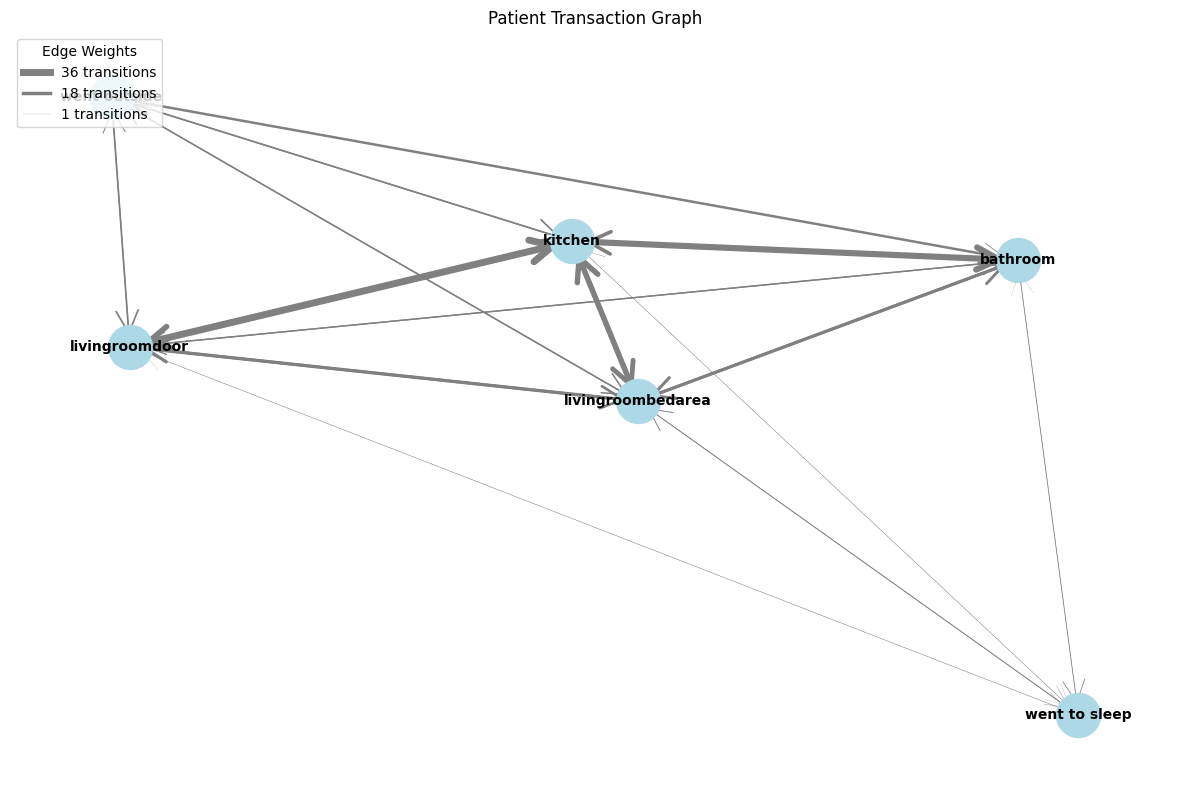

In [7]:
plot_bidirectional_transaction_graph(old_model)

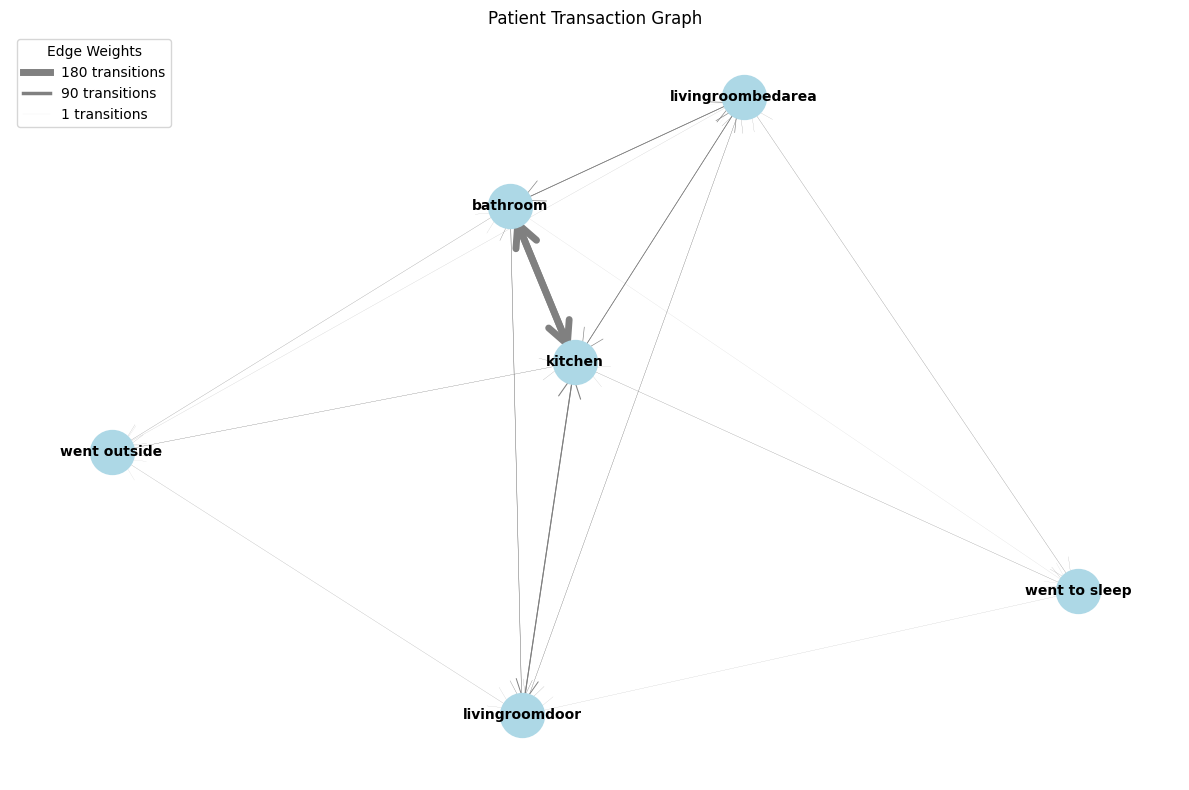

In [8]:
plot_bidirectional_transaction_graph(new_model)

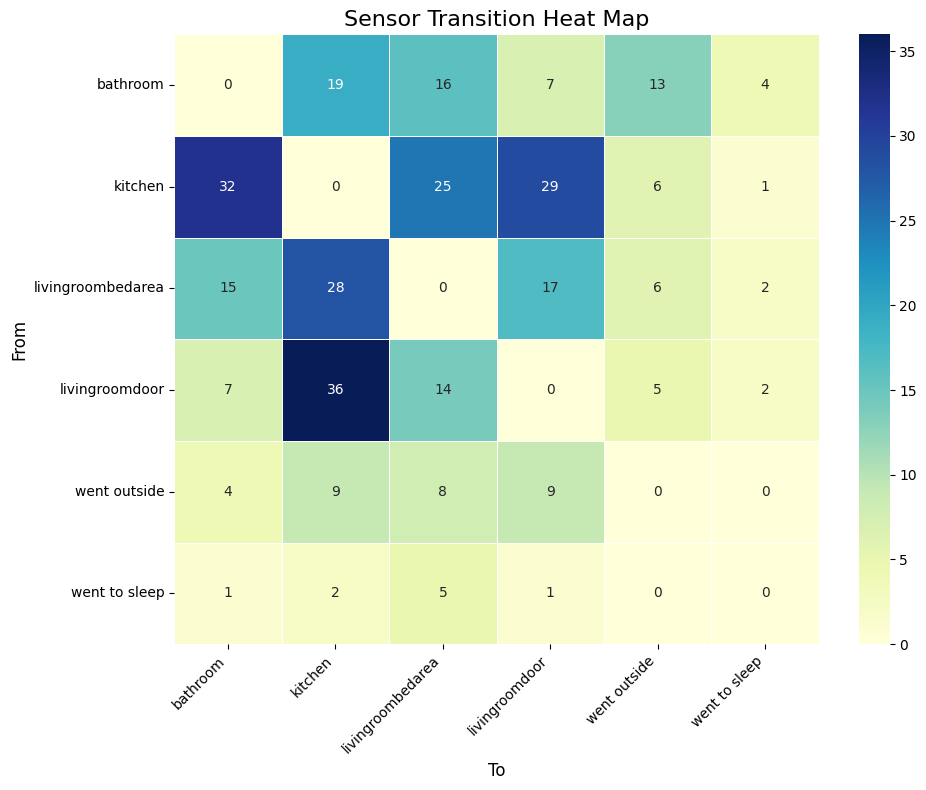

In [9]:
visualize_transitions_heatmap(old_model)

#### Counting the sleep and went outside periods

In [10]:
summary_of_sleep_time_and_time_outside(old_model)

,date,day_of_week,sleep_time,time_outside
0,2024-11-29,Friday,0,6h 16m
1,2024-11-30,Saturday,0,5h 20m
2,2024-12-01,Sunday,1h 45m,2h 28m
3,2024-12-02,Monday,8h 28m,12h 44m
4,2024-12-03,Tuesday,7h 11m,8h 57m
5,2024-12-04,Wednesday,6h 54m,4h 50m
6,2024-12-05,Thursday,4h 9m,11h 27m
7,2024-12-06,Friday,1h 37m,1h 38m


In [11]:
summary_of_sleep_time_and_time_outside(new_model)

,date,day_of_week,sleep_time,time_outside
0,2024-11-22,Friday,0h 32m,1h 35m
1,2024-11-23,Saturday,0h 46m,3h 48m
2,2024-11-24,Sunday,1h 49m,8h 19m
3,2024-11-25,Monday,6h 32m,2h 55m
4,2024-11-26,Tuesday,1h 47m,4h 56m
5,2024-11-27,Wednesday,4h 37m,1h 7m
6,2024-11-28,Thursday,6h 33m,2h 30m


#### Detect daliy trips to places

In [12]:
count_daily_visits(new_model, transition_state='bathroom')

,trip_date,bathroom_trip_count
0,2024-11-22,10
1,2024-11-23,44
2,2024-11-24,71
3,2024-11-25,20
4,2024-11-26,49
5,2024-11-27,13
6,2024-11-28,2


In [13]:
count_daily_visits(new_model, transition_state='kitchen')

,trip_date,kitchen_trip_count
0,2024-11-22,12
1,2024-11-23,41
2,2024-11-24,76
3,2024-11-25,23
4,2024-11-26,55
5,2024-11-27,13
6,2024-11-28,9


In [14]:
count_daily_visits(new_model, transition_state='livingroombedarea')

,trip_date,livingroombedarea_trip_count
0,2024-11-22,2
1,2024-11-23,21
2,2024-11-24,6
3,2024-11-25,1
4,2024-11-26,6
5,2024-11-27,7
6,2024-11-28,1


In [15]:
count_daily_visits(old_model, transition_state='livingroomdoor')

,trip_date,livingroomdoor_trip_count
0,2024-11-29,9
1,2024-11-30,13
2,2024-12-01,12
3,2024-12-02,2
4,2024-12-03,11
5,2024-12-04,10
6,2024-12-05,4
7,2024-12-06,2


### Wake up times

In [16]:
detect_wake_up_times(new_model)

,wake_up_time
26,2024-11-22 22:35:23.179
141,2024-11-24 00:14:56.818
310,2024-11-25 05:26:02.000
336,2024-11-25 17:29:48.000
361,2024-11-26 01:47:15.327
484,2024-11-27 01:54:12.349
486,2024-11-27 02:29:05.001
494,2024-11-27 08:32:14.606
525,2024-11-28 05:42:15.000
532,2024-11-28 07:18:04.909


In [17]:
detect_went_to_sleep_times(old_model)

,went_to_sleep
110,2024-12-01 22:12:10.000
112,2024-12-01 23:08:19.118
114,2024-12-02 04:23:16.000
123,2024-12-02 23:28:33.267
179,2024-12-04 00:14:02.441
183,2024-12-04 06:14:26.732
227,2024-12-05 01:14:20.083
229,2024-12-05 05:31:38.079
288,2024-12-06 01:01:32.820


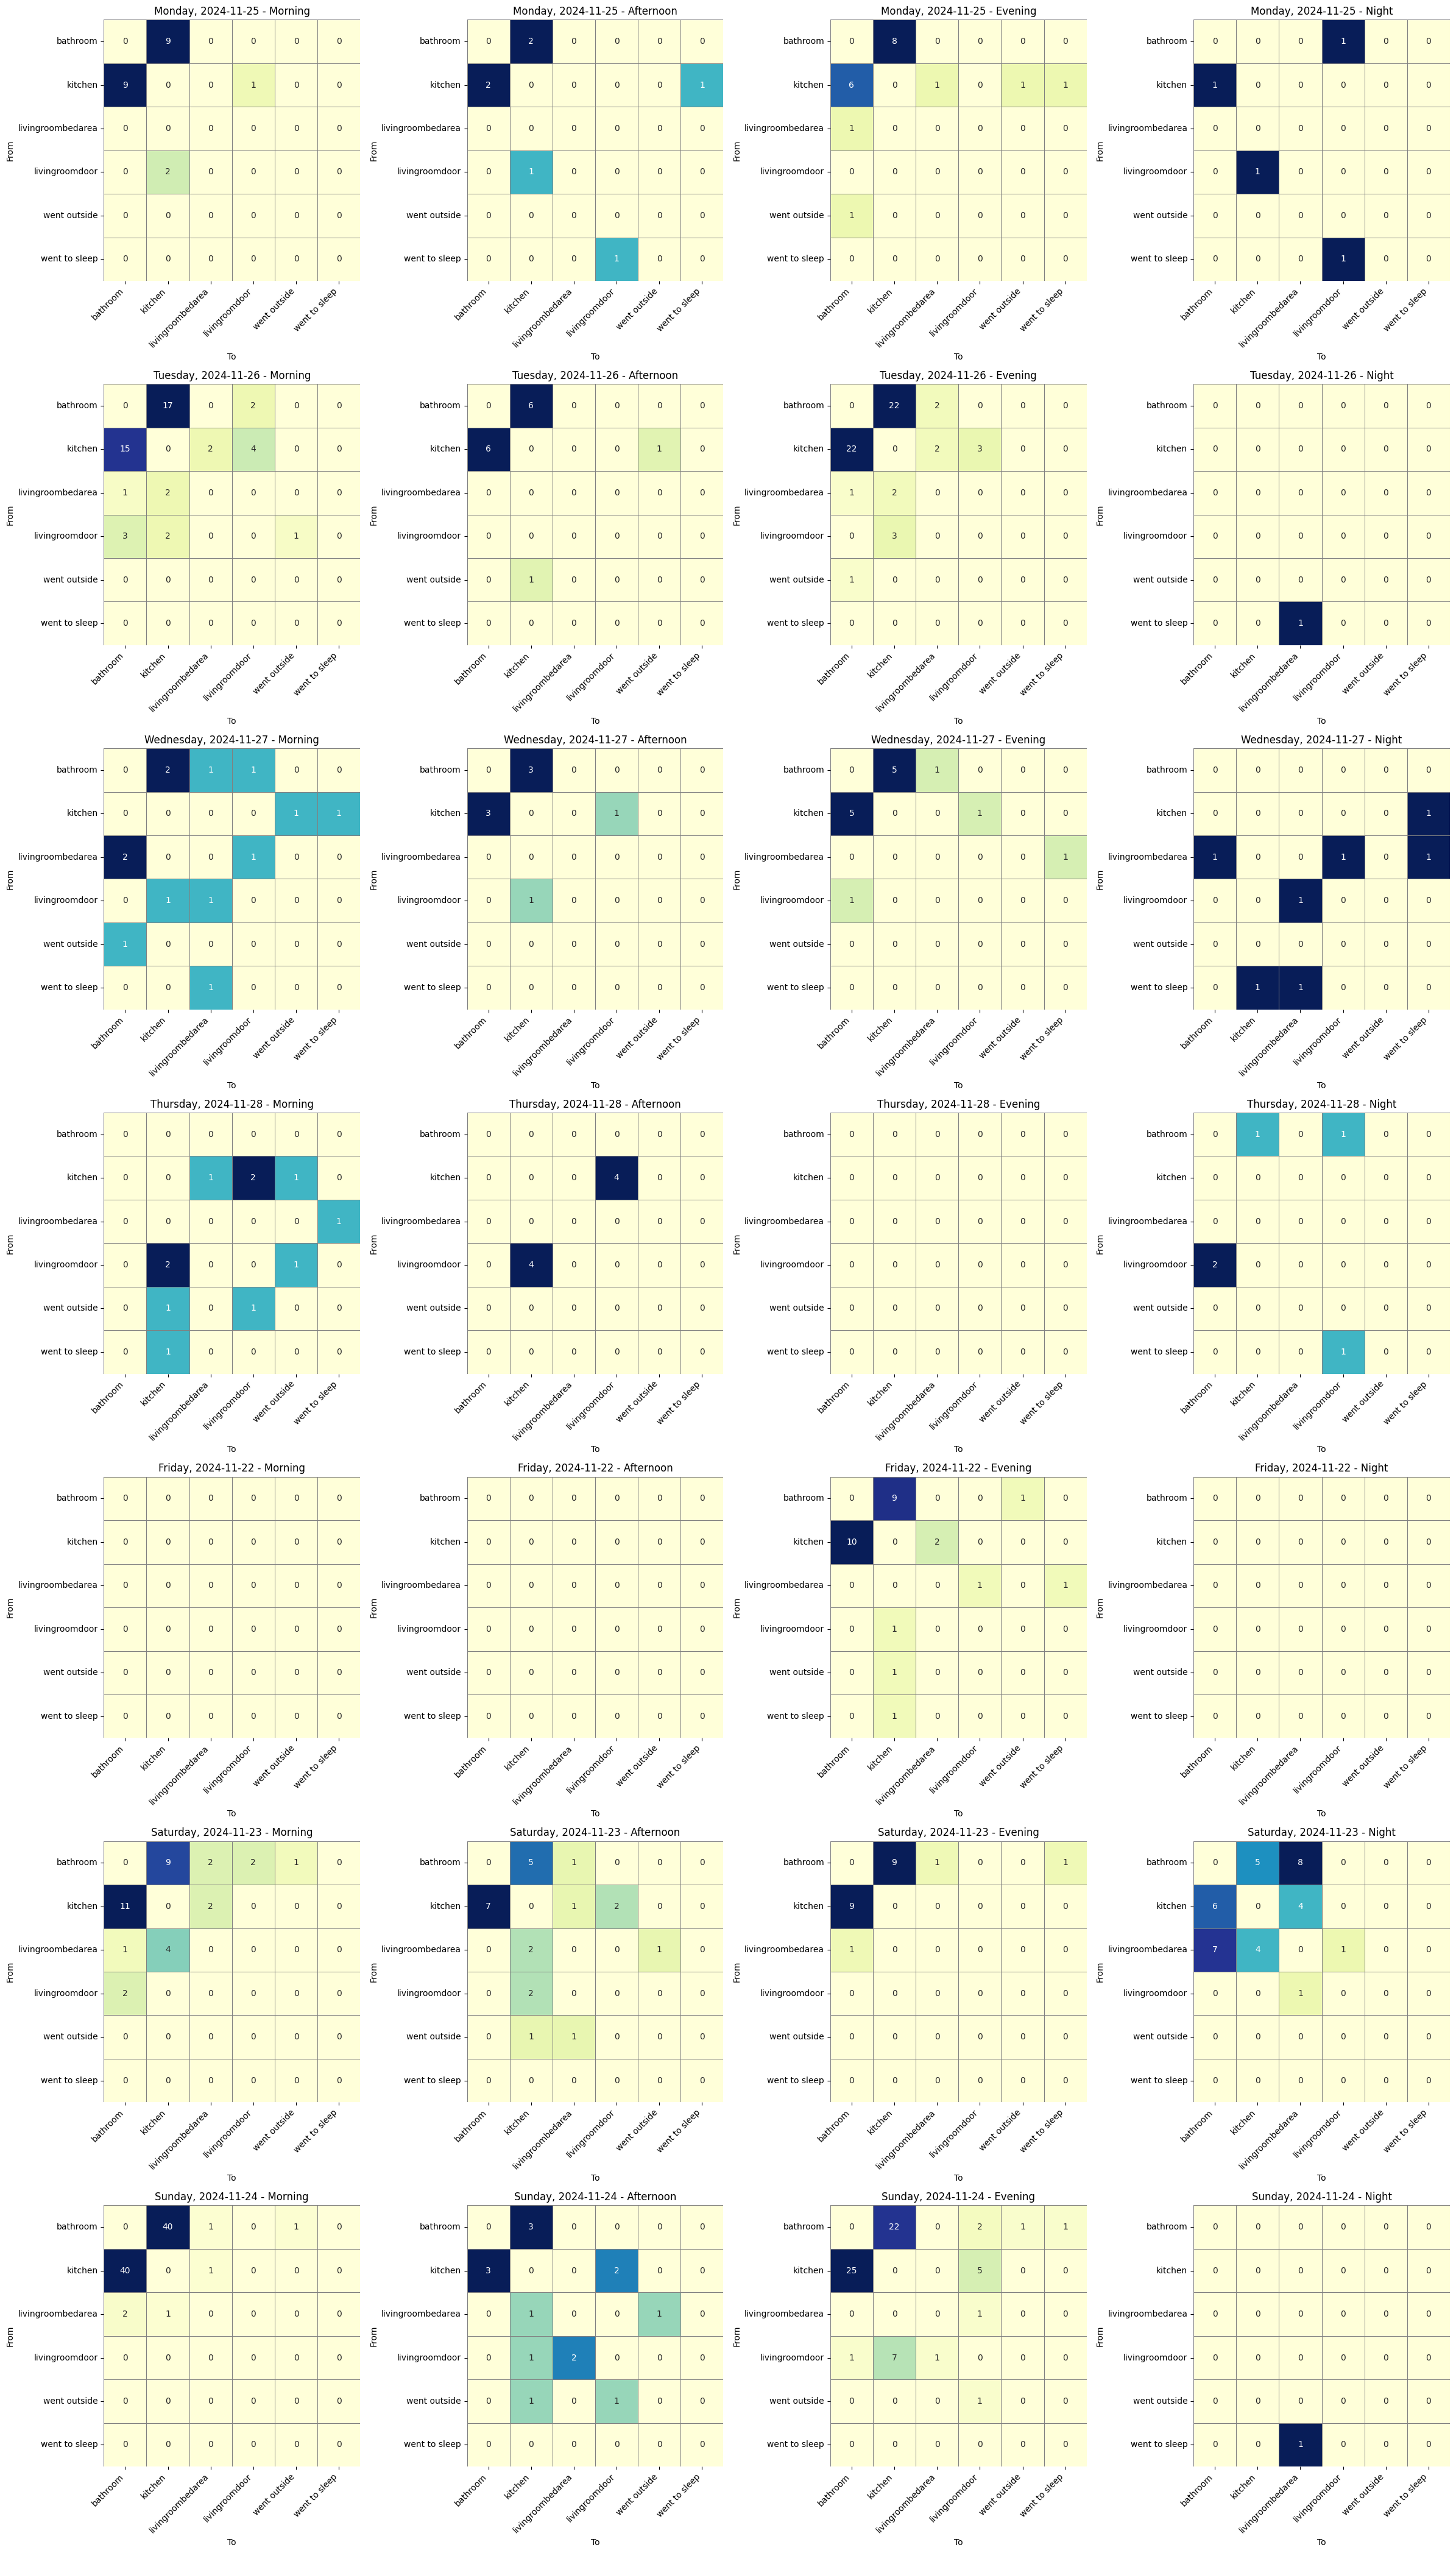

In [18]:
create_separate_heat_maps(new_model)

In [2]:
message = analyse_motion_patterns()

2025-01-03 16:43:14 [INFO] motion_analysis - 🔄 Loading old and new motion models from MinIO...
2025-01-03 16:43:14 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 16:43:14 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-03 16:43:14 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-03 16:43:14 [INFO] motion_analysis - ✅ Models loaded successfully.

2025-01-0

In [4]:
print(message)

📊 **📈 Motion Patterns Analysis Report 📉📊**

📅 **Report Date:** 2025-01-03 15:43:14 UTC

### 🕰️ **Old Motion Model** 🕰️

#### 🛌 Sleep Time and 🌳 Time Outside Summary

```      date day_of_week sleep_time time_outside
2024-11-29      Friday          0       6h 16m
2024-11-30    Saturday          0       5h 20m
2024-12-01      Sunday     1h 45m       2h 28m
2024-12-02      Monday     8h 28m      12h 44m
2024-12-03     Tuesday     7h 11m       8h 57m
2024-12-04   Wednesday     6h 54m       4h 50m
2024-12-05    Thursday      4h 9m      11h 27m
2024-12-06      Friday     1h 37m       1h 38m```

#### 🚽 **Daily Visits to Bathroom**

``` trip_date  bathroom_trip_count
2024-12-02                    2
2024-12-03                   18
2024-12-04                   10
2024-12-05                   14
2024-12-06                   15```

#### 🚽 **Daily Visits to Kitchen**

``` trip_date  kitchen_trip_count
2024-11-29                  11
2024-11-30                  23
2024-12-01                  13
2024-